In [2]:
!pip install opencv-python matplotlib


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import os

# Upload a video file in Google Colab
from google.colab import files
uploaded = files.upload()

# Get the video file name
video_path = list(uploaded.keys())[0]

# Load the video
cap = cv2.VideoCapture(video_path)

# Initialize MultiTracker
trackers = cv2.MultiTracker_create()

# Store tracking data
tracking_data = defaultdict(list)  # Stores frame-wise data

# Read the first frame
ret, frame = cap.read()
if not ret:
    print("Failed to read the video.")
    cap.release()

# Select multiple objects to track (manual selection)
num_objects = 3  # Change as needed
for i in range(num_objects):
    bbox = cv2.selectROI("Select Object", frame, fromCenter=False)
    tracker = cv2.TrackerCSRT_create()
    trackers.add(tracker, frame, bbox)

cv2.destroyAllWindows()

frame_count = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1
    success, boxes = trackers.update(frame)

    object_count = 0
    for i, newbox in enumerate(boxes):
        x, y, w, h = [int(v) for v in newbox]
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

        # Store tracking data
        tracking_data['frame'].append(frame_count)
        tracking_data['object_id'].append(i)
        tracking_data['x'].append(x)
        tracking_data['y'].append(y)
        tracking_data['width'].append(w)
        tracking_data['height'].append(h)
        tracking_data['area'].append(w * h)
        object_count += 1

    tracking_data['object_count'].append(object_count)

    # Show tracking output
    cv2.imshow("Tracking", frame)
    if cv2.waitKey(20) & 0xFF == 27:
        break

cap.release()
cv2.destroyAllWindows()

# Convert tracking data to numpy arrays
import pandas as pd
df = pd.DataFrame(tracking_data)

# Visualization 1: Number of Objects Over Time
plt.figure(figsize=(8, 5))
plt.plot(df.groupby("frame")["object_id"].nunique(), marker='o', linestyle='-', color='b')
plt.xlabel("Frame Number")
plt.ylabel("Number of Objects")
plt.title("Objects Detected Over Time")
plt.grid()
plt.show()

# Visualization 2: Object Speed Over Time
df['dx'] = df.groupby('object_id')['x'].diff().fillna(0)
df['dy'] = df.groupby('object_id')['y'].diff().fillna(0)
df['speed'] = np.sqrt(df['dx']**2 + df['dy']**2)

plt.figure(figsize=(8, 5))
for obj in df['object_id'].unique():
    plt.plot(df[df['object_id'] == obj]['frame'], df[df['object_id'] == obj]['speed'], label=f"Object {obj}")
plt.xlabel("Frame Number")
plt.ylabel("Speed (pixels/frame)")
plt.title("Speed of Objects Over Time")
plt.legend()
plt.grid()
plt.show()

# Visualization 3: Distance Traveled by Each Object
df['distance'] = df.groupby('object_id')['speed'].cumsum()

plt.figure(figsize=(8, 5))
for obj in df['object_id'].unique():
    plt.plot(df[df['object_id'] == obj]['frame'], df[df['object_id'] == obj]['distance'], label=f"Object {obj}")
plt.xlabel("Frame Number")
plt.ylabel("Total Distance Traveled (pixels)")
plt.title("Distance Covered by Objects")
plt.legend()
plt.grid()
plt.show()

# Visualization 4: Bounding Box Size Over Time
plt.figure(figsize=(8, 5))
for obj in df['object_id'].unique():
    plt.plot(df[df['object_id'] == obj]['frame'], df[df['object_id'] == obj]['area'], label=f"Object {obj}")
plt.xlabel("Frame Number")
plt.ylabel("Bounding Box Area (pixels²)")
plt.title("Bounding Box Size Variation Over Time")
plt.legend()
plt.grid()
plt.show()

# Visualization 5: Object Trajectories
plt.figure(figsize=(8, 5))
for obj in df['object_id'].unique():
    plt.plot(df[df['object_id'] == obj]['x'], df[df['object_id'] == obj]['y'], label=f"Object {obj}")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Object Trajectories")
plt.legend()
plt.gca().invert_yaxis()  # Invert y-axis for correct orientation
plt.grid()
plt.show()


Saving rainfall.csv to rainfall.csv


AttributeError: module 'cv2' has no attribute 'MultiTracker_create'

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from google.colab import files

# Upload CSV file
uploaded = files.upload()

# Load dataset
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

# Display first few rows
print(df.head())

# Ensure the dataset has a Date column
if 'Date' not in df.columns:
    print("Error: The dataset must contain a 'Date' column.")
else:
    # Convert Date column to datetime format
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')

    # Plot original data
    plt.figure(figsize=(10,5))
    plt.plot(df['Date'], df['Rainfall'], marker='o', linestyle='-')
    plt.xlabel("Date")
    plt.ylabel("Rainfall (mm)")
    plt.title("Rainfall Time Series Data")
    plt.grid()
    plt.show()

    # Convert dates to numerical values
    df['Days'] = (df['Date'] - df['Date'].min()).dt.days

    # Prepare dataset for training
    X = df[['Days']]
    y = df['Rainfall']

    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

    # Train Linear Regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Plot actual vs predicted values
    plt.figure(figsize=(10,5))
    plt.plot(df['Date'][len(X_train):], y_test, label="Actual", marker='o')
    plt.plot(df['Date'][len(X_train):], y_pred, label="Predicted", marker='x', linestyle="dashed")
    plt.xlabel("Date")
    plt.ylabel("Rainfall (mm)")
    plt.title("Actual vs Predicted Rainfall")
    plt.legend()
    plt.grid()
    plt.show()

    # Evaluate model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

    # Predict future rainfall (next 10 days)
    future_days = np.arange(df['Days'].max() + 1, df['Days'].max() + 11).reshape(-1,1)
    future_pred = model.predict(future_days)

    # Create future dates
    future_dates = pd.date_range(df['Date'].max(), periods=10, freq='D')

    # Plot future predictions
    plt.figure(figsize=(10,5))
    plt.plot(df['Date'], df['Rainfall'], label="Historical Data", marker='o', linestyle='-')
    plt.plot(future_dates, future_pred, label="Future Predictions", marker='x', linestyle="dashed", color='red')
    plt.xlabel("Date")
    plt.ylabel("Rainfall (mm)")
    plt.title("Rainfall Forecast (Next 10 Days)")
    plt.legend()
    plt.grid()
    plt.show()


Saving rainfall.csv to rainfall (1).csv
          Area  Year average_rain_fall_mm_per_year
0  Afghanistan  1985                           327
1  Afghanistan  1986                           327
2  Afghanistan  1987                           327
3  Afghanistan  1989                           327
4  Afghanistan  1990                           327
Error: The dataset must contain a 'Date' column.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from google.colab import files

# 📌 Upload CSV file
uploaded = files.upload()

# 📌 Load dataset
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

# 📌 Display first few rows
print(df.head())

# Ensure the dataset has a 'Date' column
if 'Date' not in df.columns:
    print("Error: The dataset must contain a 'Date' column.")
else:
    # Convert Date column to datetime format
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')

    # 🌟 1️⃣ Visualization: Original Time Series Plot
    plt.figure(figsize=(12,5))
    plt.plot(df['Date'], df['Rainfall'], marker='o', linestyle='-')
    plt.xlabel("Date")
    plt.ylabel("Rainfall (mm)")
    plt.title("📈 Rainfall Time Series Data")
    plt.grid()
    plt.show()

    # Convert dates to numerical values for regression
    df['Days'] = (df['Date'] - df['Date'].min()).dt.days

    # Prepare dataset
    X = df[['Days']]
    y = df['Rainfall']

    # Split dataset into 80% training, 20% testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

    # 🌟 2️⃣ Visualization: Train vs Test Split
    plt.figure(figsize=(12,5))
    plt.plot(df['Date'][:len(X_train)], y_train, label="Training Data", marker='o', linestyle="-")
    plt.plot(df['Date'][len(X_train):], y_test, label="Testing Data", marker='x', linestyle="dashed", color='red')
    plt.xlabel("Date")
    plt.ylabel("Rainfall (mm)")
    plt.title("📊 Train vs Test Data Split")
    plt.legend()
    plt.grid()
    plt.show()

    # Train Linear Regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # 🌟 3️⃣ Visualization: Actual vs Predicted Rainfall
    plt.figure(figsize=(12,5))
    plt.plot(df['Date'][len(X_train):], y_test, label="Actual", marker='o')
    plt.plot(df['Date'][len(X_train):], y_pred, label="Predicted", marker='x', linestyle="dashed", color="red")
    plt.xlabel("Date")
    plt.ylabel("Rainfall (mm)")
    plt.title("📉 Actual vs Predicted Rainfall")
    plt.legend()
    plt.grid()
    plt.show()

    # 🌟 4️⃣ Visualization: Residual Plot (Prediction Errors)
    residuals = y_test - y_pred
    plt.figure(figsize=(10,5))
    sns.histplot(residuals, bins=20, kde=True)
    plt.xlabel("Error (Residuals)")
    plt.ylabel("Frequency")
    plt.title("📊 Residual Plot (Error Distribution)")
    plt.grid()
    plt.show()

    # Evaluate model performance
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    print(f"🔹 Mean Absolute Error (MAE): {mae:.2f}")
    print(f"🔹 Root Mean Squared Error (RMSE): {rmse:.2f}")

    # Predict future rainfall (next 10 days)
    future_days = np.arange(df['Days'].max() + 1, df['Days'].max() + 11).reshape(-1,1)
    future_pred = model.predict(future_days)

    # Create future dates
    future_dates = pd.date_range(df['Date'].max() + pd.Timedelta(days=1), periods=10, freq='D')

    # 🌟 5️⃣ Visualization: Future Rainfall Prediction
    plt.figure(figsize=(12,5))
    plt.plot(df['Date'], df['Rainfall'], label="Historical Data", marker='o', linestyle='-')
    plt.plot(future_dates, future_pred, label="Future Predictions", marker='x', linestyle="dashed", color='red')
    plt.xlabel("Date")
    plt.ylabel("Rainfall (mm)")
    plt.title("🌤️ Rainfall Forecast (Next 10 Days)")
    plt.legend()
    plt.grid()
    plt.show()


Saving rainfall.csv to rainfall (2).csv
          Area  Year average_rain_fall_mm_per_year
0  Afghanistan  1985                           327
1  Afghanistan  1986                           327
2  Afghanistan  1987                           327
3  Afghanistan  1989                           327
4  Afghanistan  1990                           327
Error: The dataset must contain a 'Date' column.


Saving rainfall.csv to rainfall (3).csv
          Area  Year average_rain_fall_mm_per_year
0  Afghanistan  1985                           327
1  Afghanistan  1986                           327
2  Afghanistan  1987                           327
3  Afghanistan  1989                           327
4  Afghanistan  1990                           327


TypeError: 'value' must be an instance of str or bytes, not a float

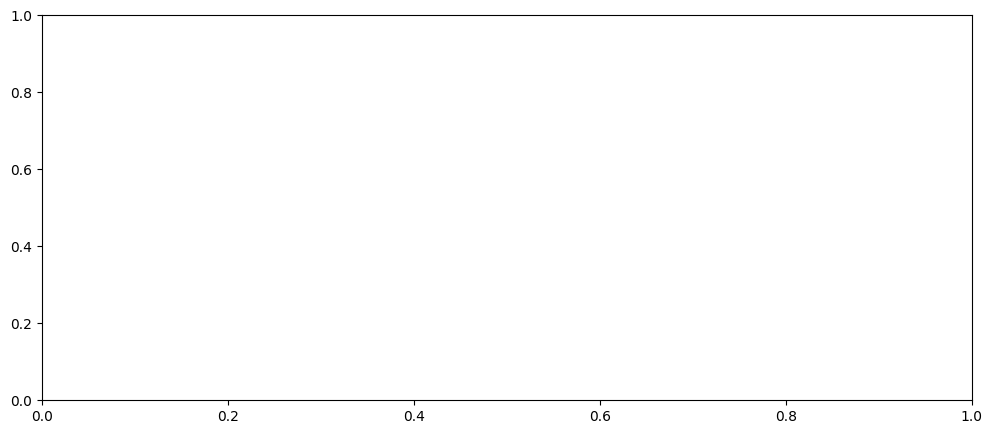

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from google.colab import files

# 📌 Upload CSV file
uploaded = files.upload()

# 📌 Load dataset
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

# 📌 Display first few rows
print(df.head())

# Ensure required columns are present
if 'Year' not in df.columns or 'average_rain_fall_mm_per_year' not in df.columns:
    print("Error: The dataset must contain 'Year' and 'average_rain_fall_mm_per_year' columns.")
else:
    # Convert 'Year' to numeric
    df['Year'] = pd.to_numeric(df['Year'])
    df = df.sort_values('Year')

    # Extract features and labels
    X = df[['Year']]
    y = df['average_rain_fall_mm_per_year']

    # 🌟 1️⃣ Visualization: Yearly Rainfall Trend
    plt.figure(figsize=(12,5))
    plt.plot(df['Year'], df['average_rain_fall_mm_per_year'], marker='o', linestyle='-')
    plt.xlabel("Year")
    plt.ylabel("Rainfall (mm)")
    plt.title("📈 Yearly Rainfall Trend")
    plt.grid()
    plt.show()

    # Split dataset into training and testing (80%-20%)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

    # 🌟 2️⃣ Visualization: Train vs Test Split
    plt.figure(figsize=(12,5))
    plt.plot(X_train, y_train, label="Training Data", marker='o', linestyle="-")
    plt.plot(X_test, y_test, label="Testing Data", marker='x', linestyle="dashed", color='red')
    plt.xlabel("Year")
    plt.ylabel("Rainfall (mm)")
    plt.title("📊 Train vs Test Data Split")
    plt.legend()
    plt.grid()
    plt.show()

    # Train Linear Regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # 🌟 3️⃣ Visualization: Actual vs Predicted Rainfall
    plt.figure(figsize=(12,5))
    plt.plot(X_test, y_test, label="Actual", marker='o')
    plt.plot(X_test, y_pred, label="Predicted", marker='x', linestyle="dashed", color="red")
    plt.xlabel("Year")
    plt.ylabel("Rainfall (mm)")
    plt.title("📉 Actual vs Predicted Rainfall")
    plt.legend()
    plt.grid()
    plt.show()

    # 🌟 4️⃣ Visualization: Residual Plot (Prediction Errors)
    residuals = y_test - y_pred
    plt.figure(figsize=(10,5))
    sns.histplot(residuals, bins=20, kde=True)
    plt.xlabel("Error (Residuals)")
    plt.ylabel("Frequency")
    plt.title("📊 Residual Plot (Error Distribution)")
    plt.grid()
    plt.show()

    # Evaluate model performance
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    print(f"🔹 Mean Absolute Error (MAE): {mae:.2f}")
    print(f"🔹 Root Mean Squared Error (RMSE): {rmse:.2f}")

    # Predict future rainfall (next 10 years)
    future_years = np.arange(df['Year'].max() + 1, df['Year'].max() + 11).reshape(-1,1)
    future_pred = model.predict(future_years)

    # 🌟 5️⃣ Visualization: Future Rainfall Prediction
    plt.figure(figsize=(12,5))
    plt.plot(df['Year'], df['average_rain_fall_mm_per_year'], label="Historical Data", marker='o', linestyle='-')
    plt.plot(future_years, future_pred, label="Future Predictions", marker='x', linestyle="dashed", color='red')
    plt.xlabel("Year")
    plt.ylabel("Rainfall (mm)")
    plt.title("🌤️ Rainfall Forecast (Next 10 Years)")
    plt.legend()
    plt.grid()
    plt.show()


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# 📌 Upload CSV file
uploaded = files.upload()

# 📌 Load dataset
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

# Display first few rows
print(df.head())

# Check column names and data types
print(df.info())

# 📌 1️⃣ Visualization: Distribution of Flights Per Year
if 'Year' in df.columns:
    plt.figure(figsize=(10, 5))
    sns.countplot(x='Year', data=df, palette="coolwarm")
    plt.xlabel("Year")
    plt.ylabel("Flight Count")
    plt.title("📊 Distribution of Flights Per Year")
    plt.xticks(rotation=45)
    plt.show()
else:
    print("⚠️ Column 'Year' not found in dataset!")

# 📌 2️⃣ Visualization: Monthly Flight Trends
if 'Month' in df.columns:
    plt.figure(figsize=(10, 5))
    sns.countplot(x='Month', data=df, order=df['Month'].value_counts().index, palette="viridis")
    plt.xlabel("Month")
    plt.ylabel("Number of Flights")
    plt.title("📈 Monthly Flight Trends")
    plt.show()
else:
    print("⚠️ Column 'Month' not found in dataset!")

# 📌 3️⃣ Visualization: Flight Delays by Airline
if 'Airline' in df.columns and 'Delay' in df.columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Airline', y='Delay', data=df, palette="pastel")
    plt.xlabel("Airline")
    plt.ylabel("Delay (minutes)")
    plt.title("⏳ Flight Delays by Airline")
    plt.xticks(rotation=45)
    plt.show()
else:
    print("⚠️ Columns 'Airline' or 'Delay' not found in dataset!")

# 📌 4️⃣ Visualization: Flights Per Airport
if 'Origin_Airport' in df.columns:
    plt.figure(figsize=(12, 6))
    df['Origin_Airport'].value_counts().head(10).plot(kind='bar', color='teal')
    plt.xlabel("Airport")
    plt.ylabel("Number of Flights")
    plt.title("✈️ Top 10 Busiest Airports")
    plt.xticks(rotation=45)
    plt.show()
else:
    print("⚠️ Column 'Origin_Airport' not found in dataset!")

# 📌 5️⃣ Visualization: Heatmap of Flight Correlations
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("🔎 Correlation Between Flight Features")
plt.show()


Saving flights.csv to flights.csv
   index      Airline Date_of_Journey    Source Destination Dep_Time Duration  \
0      0  Jet Airways      2019-01-03  Banglore   New Delhi    11:40   13h 5m   
1      1     SpiceJet      2019-01-03  Banglore   New Delhi    15:35    8h 5m   
2      2  Jet Airways      2019-01-03  Banglore   New Delhi     8:00  12h 20m   
3      3    Air India      2019-01-03  Banglore   New Delhi     8:50   39h 5m   
4      4  Jet Airways      2019-01-03  Banglore   New Delhi    11:40  23h 45m   

  Total_Stops Additional_Info  Price  
0      1 stop         No info  26890  
1      1 stop  1 Long layover   7744  
2      1 stop         No info  27992  
3     2 stops         No info  17135  
4      1 stop         No info  25735  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   index            10683 non-null  int64 
 

ValueError: could not convert string to float: 'Jet Airways'

<Figure size 1000x600 with 0 Axes>

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# 📌 Upload CSV file
uploaded = files.upload()

# 📌 Load dataset
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

# Display first few rows
print(df.head())

# Check column names and data types
print(df.info())

# 📌 1️⃣ Visualization: Number of Flights Per Year
if 'Year' in df.columns:
    plt.figure(figsize=(10, 5))
    sns.countplot(x='Year', data=df, palette="coolwarm")
    plt.xlabel("Year")
    plt.ylabel("Flight Count")
    plt.title("📊 Number of Flights Per Year")
    plt.xticks(rotation=45)
    plt.show()
else:
    print("⚠️ Column 'Year' not found in dataset!")

# 📌 2️⃣ Visualization: Flight Count by Month
if 'Month' in df.columns:
    plt.figure(figsize=(10, 5))
    sns.countplot(x='Month', data=df, order=df['Month'].value_counts().index, palette="viridis")
    plt.xlabel("Month")
    plt.ylabel("Number of Flights")
    plt.title("📈 Monthly Flight Trends")
    plt.show()
else:
    print("⚠️ Column 'Month' not found in dataset!")

# 📌 3️⃣ Visualization: Average Flight Delay by Airline
if 'Airline' in df.columns and 'Delay' in df.columns:
    plt.figure(figsize=(12, 6))
    avg_delay = df.groupby('Airline')['Delay'].mean().sort_values()
    avg_delay.plot(kind='barh', color='salmon')
    plt.xlabel("Average Delay (minutes)")
    plt.ylabel("Airline")
    plt.title("⏳ Average Flight Delay by Airline")
    plt.show()
else:
    print("⚠️ Columns 'Airline' or 'Delay' not found in dataset!")

# 📌 4️⃣ Visualization: Top 10 Airports with Most Flights
if 'Origin_Airport' in df.columns:
    plt.figure(figsize=(12, 6))
    df['Origin_Airport'].value_counts().head(10).plot(kind='bar', color='teal')
    plt.xlabel("Airport")
    plt.ylabel("Number of Flights")
    plt.title("✈️ Top 10 Busiest Airports")
    plt.xticks(rotation=45)
    plt.show()
else:
    print("⚠️ Column 'Origin_Airport' not found in dataset!")

# 📌 5️⃣ Visualization: Flight Route Network (Departure vs Destination)
if 'Origin_Airport' in df.columns and 'Destination_Airport' in df.columns:
    plt.figure(figsize=(10, 5))
    route_counts = df.groupby(['Origin_Airport', 'Destination_Airport']).size().reset_index(name='Flight Count')
    sns.scatterplot(x=route_counts['Origin_Airport'], y=route_counts['Destination_Airport'], size=route_counts['Flight Count'], legend=False, color="darkblue")
    plt.xlabel("Departure Airport")
    plt.ylabel("Destination Airport")
    plt.title("🛫 Flight Route Network")
    plt.xticks(rotation=90)
    plt.show()
else:
    print("⚠️ Columns 'Origin_Airport' or 'Destination_Airport' not found in dataset!")


Saving flights.csv to flights (1).csv
   index      Airline Date_of_Journey    Source Destination Dep_Time Duration  \
0      0  Jet Airways      2019-01-03  Banglore   New Delhi    11:40   13h 5m   
1      1     SpiceJet      2019-01-03  Banglore   New Delhi    15:35    8h 5m   
2      2  Jet Airways      2019-01-03  Banglore   New Delhi     8:00  12h 20m   
3      3    Air India      2019-01-03  Banglore   New Delhi     8:50   39h 5m   
4      4  Jet Airways      2019-01-03  Banglore   New Delhi    11:40  23h 45m   

  Total_Stops Additional_Info  Price  
0      1 stop         No info  26890  
1      1 stop  1 Long layover   7744  
2      1 stop         No info  27992  
3     2 stops         No info  17135  
4      1 stop         No info  25735  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   index            10683 non-null  int6

Saving flights.csv to flights (2).csv
   index      Airline Date_of_Journey    Source Destination Dep_Time Duration  \
0      0  Jet Airways      2019-01-03  Banglore   New Delhi    11:40   13h 5m   
1      1     SpiceJet      2019-01-03  Banglore   New Delhi    15:35    8h 5m   
2      2  Jet Airways      2019-01-03  Banglore   New Delhi     8:00  12h 20m   
3      3    Air India      2019-01-03  Banglore   New Delhi     8:50   39h 5m   
4      4  Jet Airways      2019-01-03  Banglore   New Delhi    11:40  23h 45m   

  Total_Stops Additional_Info  Price  Day  Month  Year  
0      1 stop         No info  26890    3      1  2019  
1      1 stop  1 Long layover   7744    3      1  2019  
2      1 stop         No info  27992    3      1  2019  
3     2 stops         No info  17135    3      1  2019  
4      1 stop         No info  25735    3      1  2019  


<ipython-input-9-b410d5c30555>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Airline', data=df, palette="coolwarm", order=df['Airline'].value_counts().index)


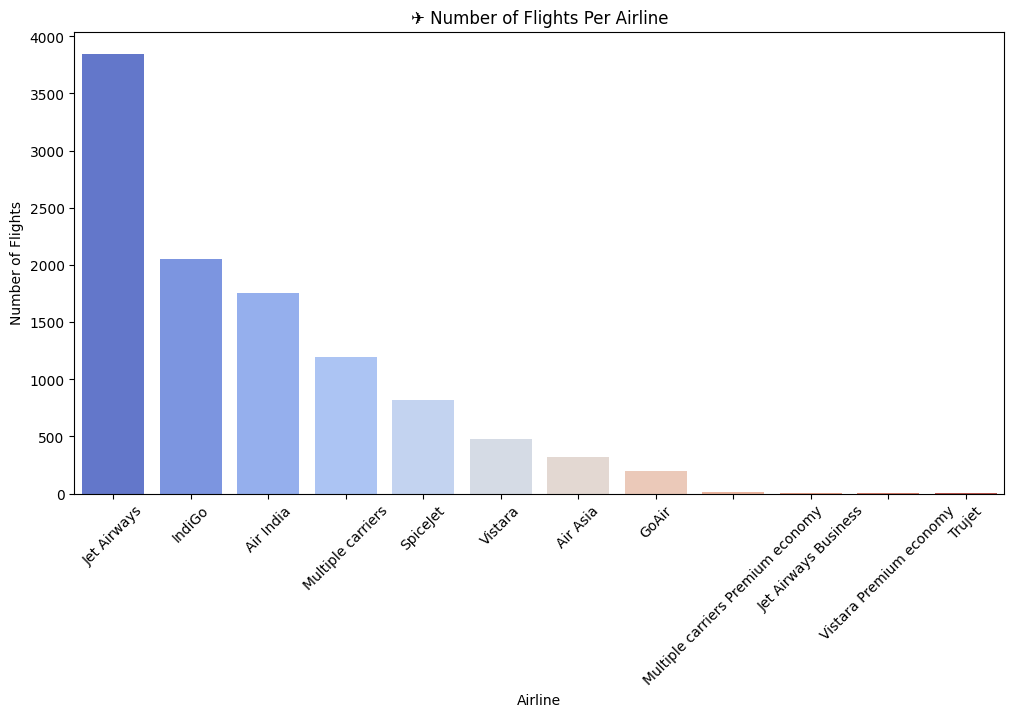

<ipython-input-9-b410d5c30555>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Airline', y='Price', data=df, palette="viridis")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


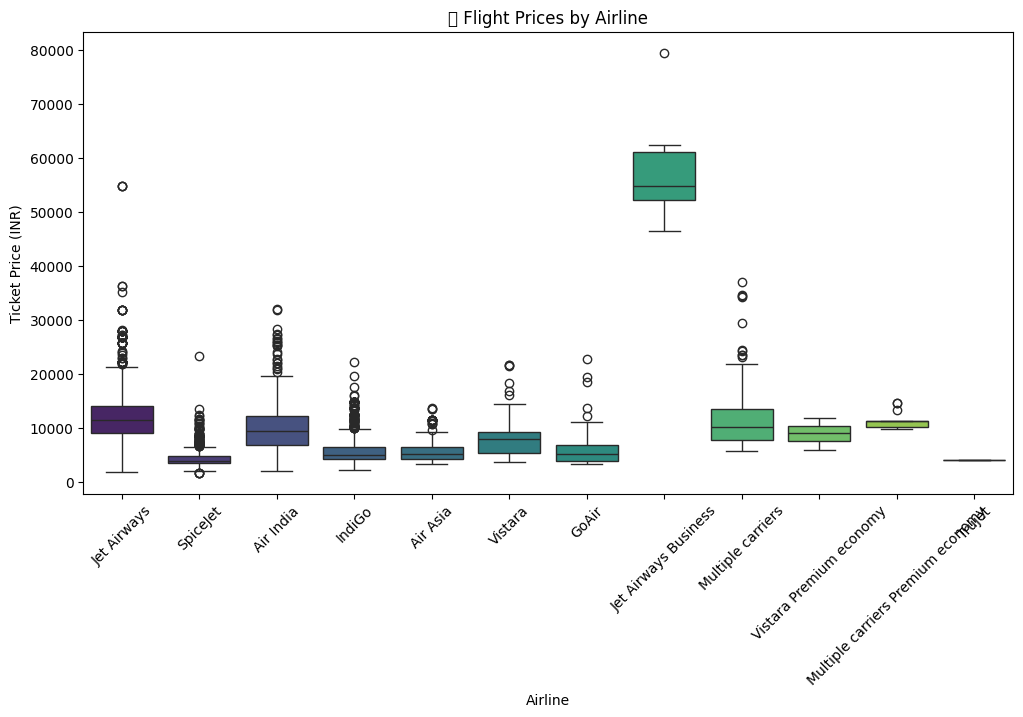

<ipython-input-9-b410d5c30555>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Month', data=df, palette="magma")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128198 (\N{TEAR-OFF CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


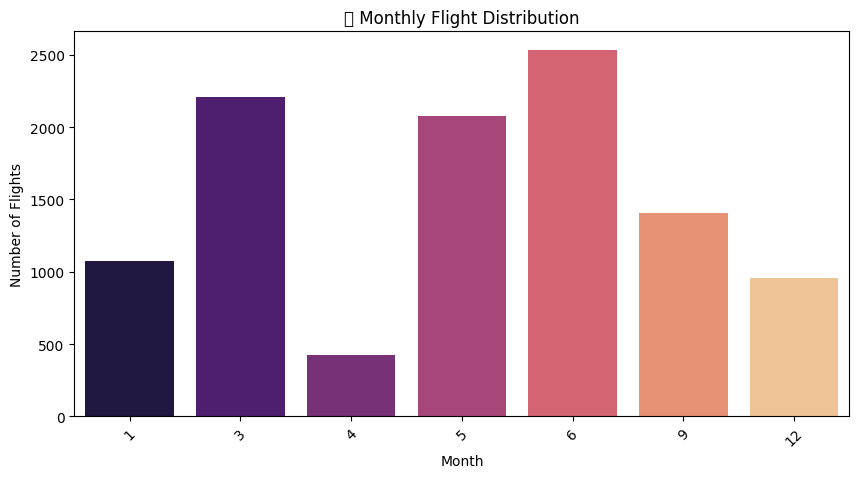

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


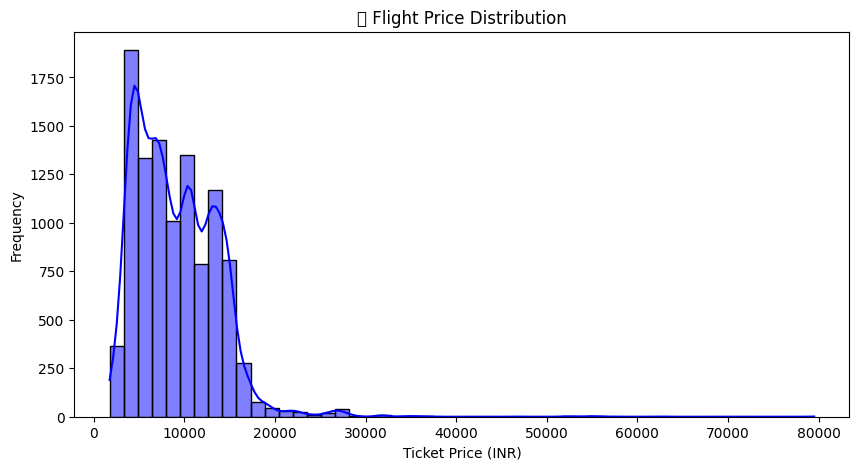

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9203 (\N{HOURGLASS WITH FLOWING SAND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


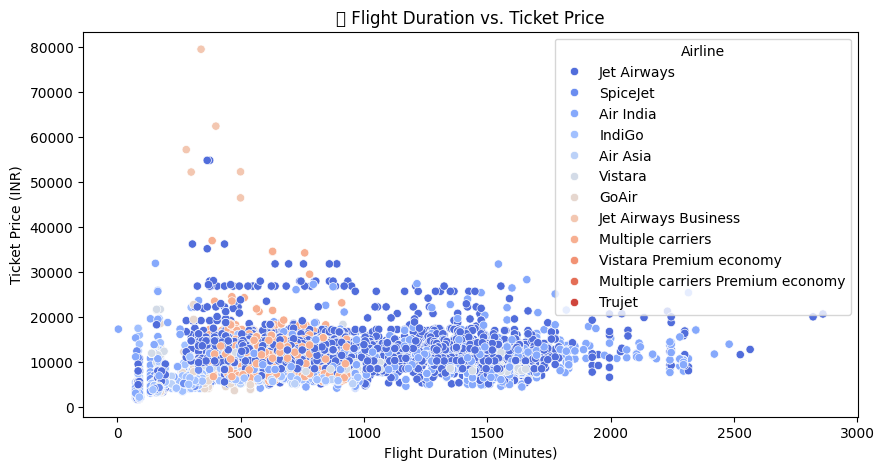

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# 📌 Upload and Load Dataset
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

# Convert Date_of_Journey to datetime format
df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'])

# Extract 'Day', 'Month', 'Year' from 'Date_of_Journey'
df['Day'] = df['Date_of_Journey'].dt.day
df['Month'] = df['Date_of_Journey'].dt.month
df['Year'] = df['Date_of_Journey'].dt.year

# Display dataset info
print(df.head())

# 📌 1️⃣ Visualization: Number of Flights Per Airline
plt.figure(figsize=(12, 6))
sns.countplot(x='Airline', data=df, palette="coolwarm", order=df['Airline'].value_counts().index)
plt.xlabel("Airline")
plt.ylabel("Number of Flights")
plt.title("✈️ Number of Flights Per Airline")
plt.xticks(rotation=45)
plt.show()

# 📌 2️⃣ Visualization: Flight Prices by Airline
plt.figure(figsize=(12, 6))
sns.boxplot(x='Airline', y='Price', data=df, palette="viridis")
plt.xlabel("Airline")
plt.ylabel("Ticket Price (INR)")
plt.title("💰 Flight Prices by Airline")
plt.xticks(rotation=45)
plt.show()

# 📌 3️⃣ Visualization: Number of Flights Per Month
plt.figure(figsize=(10, 5))
sns.countplot(x='Month', data=df, palette="magma")
plt.xlabel("Month")
plt.ylabel("Number of Flights")
plt.title("📆 Monthly Flight Distribution")
plt.xticks(rotation=45)
plt.show()

# 📌 4️⃣ Visualization: Flight Price Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['Price'], bins=50, kde=True, color="blue")
plt.xlabel("Ticket Price (INR)")
plt.ylabel("Frequency")
plt.title("📊 Flight Price Distribution")
plt.show()

# 📌 5️⃣ Visualization: Duration of Flights
plt.figure(figsize=(10, 5))
df['Duration_in_Minutes'] = df['Duration'].str.replace('h', '*60').str.replace('m', '').str.replace(' ', '+').apply(eval)
sns.scatterplot(x=df['Duration_in_Minutes'], y=df['Price'], hue=df['Airline'], palette="coolwarm")
plt.xlabel("Flight Duration (Minutes)")
plt.ylabel("Ticket Price (INR)")
plt.title("⏳ Flight Duration vs. Ticket Price")
plt.show()
